In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from shapely.geometry import Point, LineString
from shapely.geometry import LineString, Point
from scipy.spatial import cKDTree

%matplotlib inline

pd.set_option("display.max_columns", 100)

In [6]:
# get dataset
df = gpd.read_file('./road.gpkg', layer='wegvakken')

In [10]:
# df.to_parquet('./wegvakken.parquet')
df.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [ ]:
minx, miny, maxx, maxy = 124457, 445782, 146990, 464462
bbox = (minx, miny, maxx, maxy)

# Crop the GeoDataFrame using the bounding box
ut = df.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
# Optionally, save the cropped GeoDataFrame to a new file
ut.to_parquet('utrecht.parquet')

In [22]:
# utrecht.head()
ut = ut[['objectid','wvk_id','wvk_begdat','st_lengthshape','geometry']]
ut.head()

,objectid,wvk_id,wvk_begdat,st_lengthshape,geometry
62,96,600195776.0,2019-08-01 00:00:00+00:00,5.213405,"MULTILINESTRING ((141122.918 447780.379, 14112..."
107,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"MULTILINESTRING ((144609.836 450717.961, 14460..."
224,223,276315001.0,2020-12-01 00:00:00+00:00,247.420097,"MULTILINESTRING ((138180.068 457868.143, 13817..."
231,230,291310030.0,2020-12-01 00:00:00+00:00,22.340021,"MULTILINESTRING ((145778.46 455101.553, 145783..."
240,239,267297164.0,2020-12-01 00:00:00+00:00,94.653877,"MULTILINESTRING ((133915.746 448769.847, 13390..."


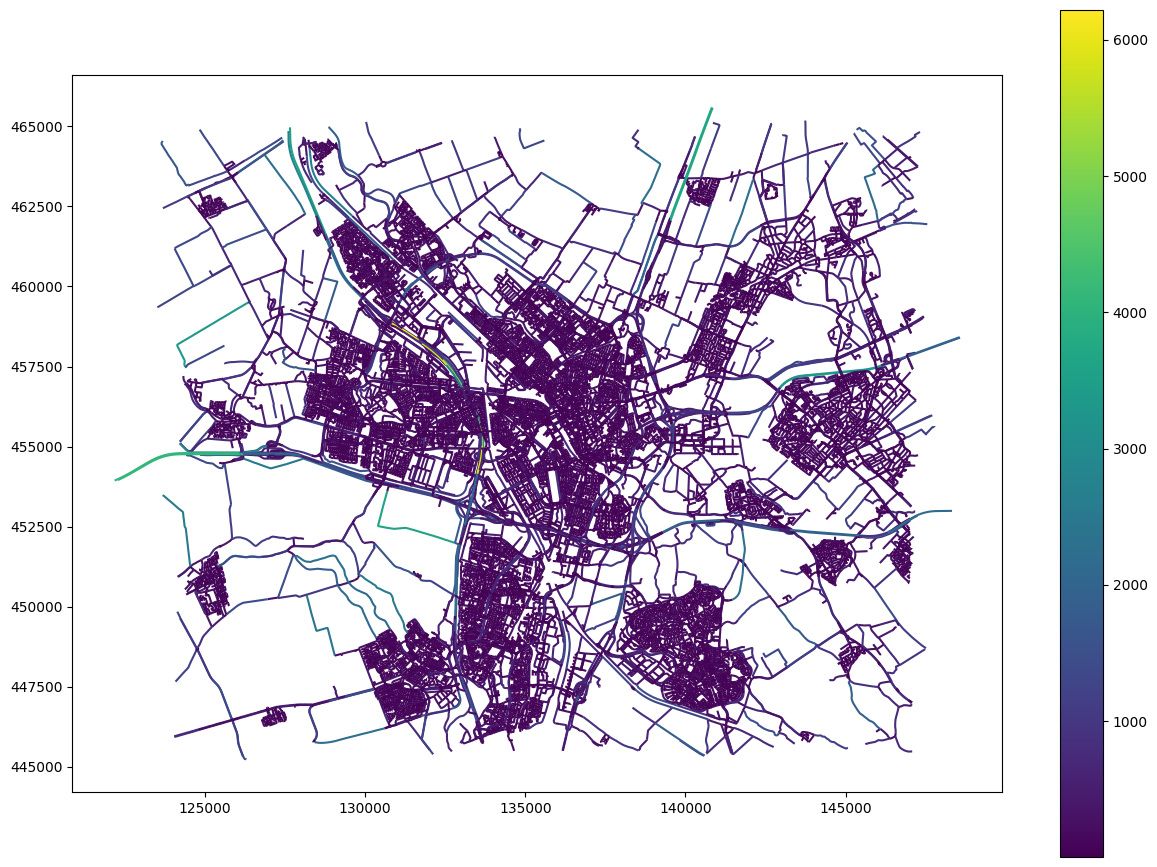

In [81]:
base = ut.plot(column = 'st_lengthshape'
        ,legend=True
        ,figsize=(15,11)
        )

In [27]:
# 2. Explode any MultiLineStrings into individual LineStrings
ut = ut.explode(index_parts=False).reset_index(drop=True)

# 3. Build the segment‐list column in one apply
def extract_segments(geom):
    """
    Given a LineString or (now exploded) single-part geometry,
    break it into a list of tiny LineStrings between each pair of coords.
    """
    coords = list(geom.coords)
    return [ LineString([coords[i], coords[i+1]]) 
             for i in range(len(coords)-1) ]

ut["segments"] = ut.geometry.apply(extract_segments)
ut

,objectid,wvk_id,wvk_begdat,st_lengthshape,geometry,segments
0,96,600195776.0,2019-08-01 00:00:00+00:00,5.213405,"LINESTRING (141122.918 447780.379, 141127.735 ...",[LINESTRING (141122.91800000146 447780.3790999...
1,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",[LINESTRING (144609.83619999886 450717.9609000...
2,223,276315001.0,2020-12-01 00:00:00+00:00,247.420097,"LINESTRING (138180.068 457868.143, 138179.456 ...",[LINESTRING (138180.06799999997 457868.1433000...
3,230,291310030.0,2020-12-01 00:00:00+00:00,22.340021,"LINESTRING (145778.46 455101.553, 145783 45510...",[LINESTRING (145778.4598999992 455101.55319999...
4,239,267297164.0,2020-12-01 00:00:00+00:00,94.653877,"LINESTRING (133915.746 448769.847, 133909.864 ...",[LINESTRING (133915.74599999934 448769.8469999...
...,...,...,...,...,...,...
49639,1578396,600691756.0,2022-03-01 00:00:00+00:00,11.250500,"LINESTRING (132304.29 457421.58, 132305.32 457...",[LINESTRING (132304.2901000008 457421.58040000...
49640,1578418,258323029.0,2024-06-01 00:00:00+00:00,49.739850,"LINESTRING (129402.52 461745.029, 129403.431 4...",[LINESTRING (129402.51979999989 461745.0291999...
49641,1578477,600128453.0,2023-04-01 00:00:00+00:00,814.937716,"LINESTRING (140385.962 456090.673, 140346.049 ...",[LINESTRING (140385.96159999818 456090.6730000...
49642,1578505,600776784.0,2024-06-01 00:00:00+00:00,33.427675,"LINESTRING (135897.394 458277.926, 135922.077 ...",[LINESTRING (135897.3942000009 458277.92639999...


In [48]:

# 3. Explode so each row = one segment
segs = ut.explode("segments").reset_index(drop=True)
segs = segs.rename(columns={"segments": "geom"})
# 4. Vectorized extraction of endpoints and cost
#    (these are simple Series operations over the exploded GeoDataFrame)
segs["u"] = segs.geom.apply(lambda s: tuple(s.coords[0]))
segs["v"] = segs.geom.apply(lambda s: tuple(s.coords[-1]))
segs["weight"] = segs.geom.astype('geometry').apply(lambda x: x.length)
segs

,objectid,wvk_id,wvk_begdat,st_lengthshape,geometry,geom,u,v,weight
0,96,600195776.0,2019-08-01 00:00:00+00:00,5.213405,"LINESTRING (141122.918 447780.379, 141127.735 ...",LINESTRING (141122.91800000146 447780.37909999...,"(141122.91800000146, 447780.3790999986)","(141127.73479999974, 447782.37359999865)",5.213405
1,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",LINESTRING (144609.83619999886 450717.96090000...,"(144609.83619999886, 450717.9609000012)","(144604.3302000016, 450716.6722000018)",5.654802
2,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",LINESTRING (144604.3302000016 450716.672200001...,"(144604.3302000016, 450716.6722000018)","(144601.79019999877, 450716.3546999991)",2.559767
3,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",LINESTRING (144601.79019999877 450716.35469999...,"(144601.79019999877, 450716.3546999991)","(144598.9327000007, 450717.78350000083)",3.194804
4,107,600397430.0,2020-07-01 00:00:00+00:00,129.918712,"LINESTRING (144609.836 450717.961, 144604.33 4...",LINESTRING (144598.9327000007 450717.783500000...,"(144598.9327000007, 450717.78350000083)","(144592.90019999817, 450722.06969999894)",7.400173
...,...,...,...,...,...,...,...,...,...
321180,1578521,288303083.0,2020-12-01 00:00:00+00:00,128.469928,"LINESTRING (144460.202 451647.669, 144461.533 ...",LINESTRING (144461.53299999982 451651.30999999...,"(144461.53299999982, 451651.30999999866)","(144481.19999999925, 451664.618999999)",23.747008
321181,1578521,288303083.0,2020-12-01 00:00:00+00:00,128.469928,"LINESTRING (144460.202 451647.669, 144461.533 ...",LINESTRING (144481.19999999925 451664.61899999...,"(144481.19999999925, 451664.618999999)","(144486.45600000024, 451666.3990000002)",5.549228
321182,1578521,288303083.0,2020-12-01 00:00:00+00:00,128.469928,"LINESTRING (144460.202 451647.669, 144461.533 ...",LINESTRING (144486.45600000024 451666.39900000...,"(144486.45600000024, 451666.3990000002)","(144505.5300000012, 451670.21400000155)",19.451779
321183,1578521,288303083.0,2020-12-01 00:00:00+00:00,128.469928,"LINESTRING (144460.202 451647.669, 144461.533 ...",LINESTRING (144505.5300000012 451670.214000001...,"(144505.5300000012, 451670.21400000155)","(144561.94799999893, 451666.44200000167)",56.543954


In [49]:
# 5. Build the NetworkX graph in one shot
G = nx.from_pandas_edgelist(
    segs, 
    source="u", 
    target="v", 
    edge_attr=["weight", "geom"],
    create_using=nx.Graph()
)
G

In [51]:
me = me_x, me_y = 136186.913,457406.166

station = station_x, station_y = 135989.6,455726.2

In [53]:
station_x

135989.6

In [ ]:
# # 6. Snap & route exactly as before
# def nearest_node(G, pt):
#     return min(G.nodes, key=lambda n: Point(n).distance(Point(pt)))

# start = nearest_node(G, me)
# end   = nearest_node(G, station)
# start


(136182.47509999946, 457414.7217000015)

In [ ]:

# Build KD-tree on node coordinates once
node_coords = np.array(list(G.nodes()))          # shape (N,2)
kdtree      = cKDTree(node_coords)

def nearest_node(pt):
    _, idx = kdtree.query(pt)
    return tuple(node_coords[idx])


# snap your two points
start = nearest_node(me)
end   = nearest_node(station)

start


(np.float64(136182.47509999946), np.float64(457414.7217000015))

In [86]:

# compute shortest path (Dijkstra)
path = nx.shortest_path(G, source=start, target=end, weight="cost")

# stitch the segment geoms back together
route_segs = [ G[u][v]["geom"] for u,v in zip(path[:-1], path[1:]) ]
route_line = LineString([pt for seg in route_segs for pt in seg.coords])

# now you can wrap that in a GeoDataFrame, plot it, save it, etc.
route = gpd.GeoDataFrame({"id":[1]}, geometry=[route_line], crs="EPSG:28992")
# route.to_file("shortest_route.GeoJSON", driver='GEOJSON')
route

,id,geometry
0,1,"LINESTRING (136182.475 457414.722, 136184.938 ..."


In [143]:
route.to_file('path.geoJSON', driver = 'GEOJSON')

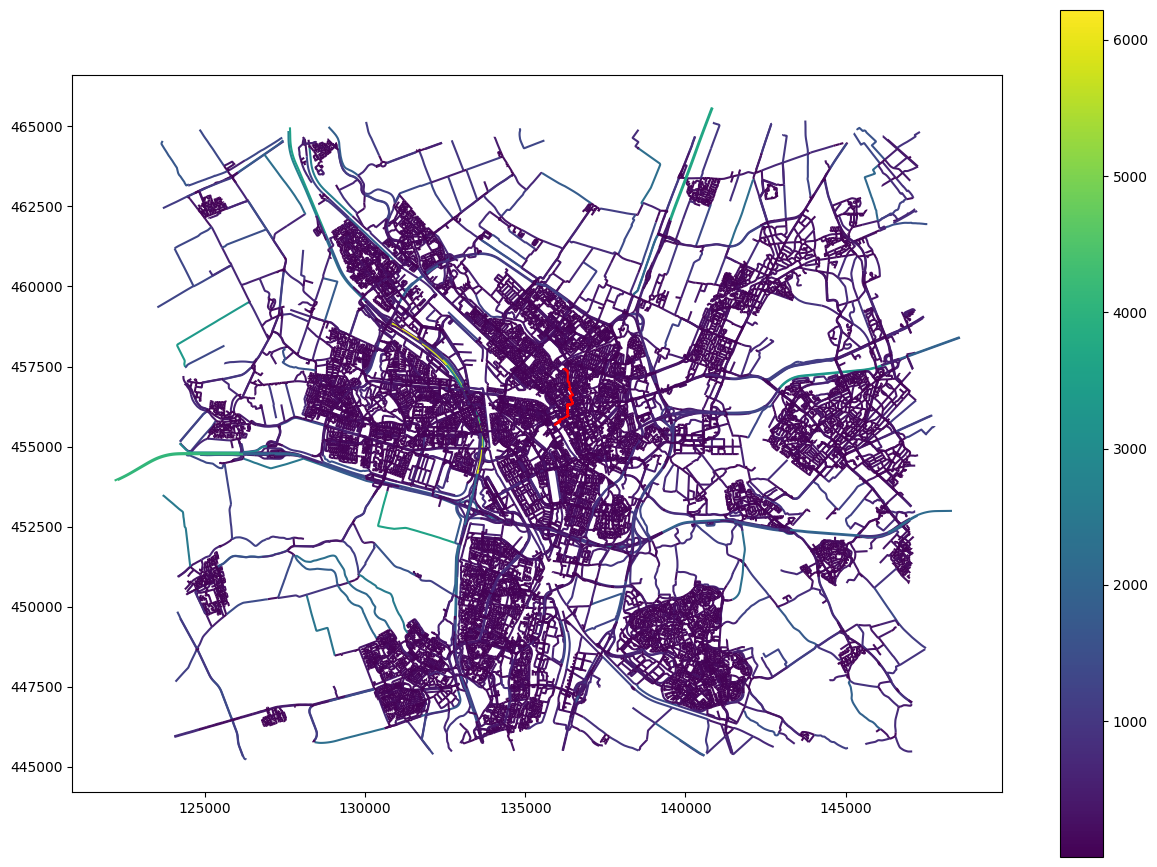

In [82]:
base = ut.plot(column = 'st_lengthshape'
        ,legend=True
        ,figsize=(15,11)
        )
route.plot(color='red', ax=base)
plt.show()

In [ ]:
# display interactive folium map

In [133]:
def interactive_map_notebook(df, df2):
    # Create a base folium map centered on df's centroid (or default location)
    centroid = df.geometry.union_all().centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=6)
    # Add first GeoDataFrame to map with a blue style

    df_tooltip_fields = df.columns.tolist()
    df_tooltip_fields.remove('geometry')
    folium.GeoJson(
        df.__geo_interface__,
        name='Base Layer',
        style_function=lambda x: {'color': 'blue', 'weight': 1, 'fillOpacity': 0.4},
        tooltip=folium.GeoJsonTooltip(fields=df_tooltip_fields)
    ).add_to(m)
    # Add second GeoDataFrame to map with a red style
    df2_tooltip_fields = df2.columns.tolist()
    df2_tooltip_fields.remove('geometry')
    folium.GeoJson(
        df2.__geo_interface__,
        name='Overlay Layer',
        style_function=lambda x: {'color': 'red', 'weight': 3, 'fillOpacity': 0.4},
        tooltip=folium.GeoJsonTooltip(fields=df2_tooltip_fields)
    ).add_to(m)
    # Add layer control so you can toggle layers on/off
    folium.LayerControl().add_to(m)
    return m

In [139]:
# del utrecht
# del df

In [142]:
# basedf = ut.drop(columns = ['wvk_begdat', 'segments'])
# interactive_map_notebook(basedf.to_crs(4326), route.to_crs(4326))

In [130]:
_ = basedf.columns.tolist()
_

['objectid', 'wvk_id', 'st_lengthshape', 'geometry']

<?xml version="1.0" encoding="UTF-8"?>
<feed xmlns="http://www.w3.org/2005/Atom" xmlns:georss="http://www.georss.org/georss" xmlns:inspire_dls="http://inspire.ec.europa.eu/schemas/inspire_dls/1.0" xml:lang="nl">
 <id>https://service.pdok.nl/rws/nwbwegen/atom/index.xml</id>
 <title>NWB - Wegen ATOM</title>
 <subtitle>NWB - Wegen ATOM</subtitle>
 <link href="https://service.pdok.nl/rws/nwbwegen/atom/index.xml" rel="self" type="application/atom+xml" hreflang="nl" title="NWB - Wegen ATOM"></link>
 <link href="https://www.nationaalgeoregister.nl/geonetwork/srv/dut/csw?service=CSW&version=2.0.2&request=GetRecordById&outputschema=http://www.isotc211.org/2005/gmd&elementsetname=full&id=71b8214f-7525-45bd-bdee-2c60f32a1725" rel="describedby" type="application/xml" hreflang="nl"></link>
 <link href="https://www.nationaalgeoregister.nl/geonetwork/opensearch/dut/71b8214f-7525-45bd-bdee-2c60f32a1725/OpenSearchDescription.xml" rel="search" type="application/opensearchdescription+xml" hreflang="nl" title="Open Search document voor INSPIRE Download service PDOK"></link>
 <link href="https://www.nationaalgeoregister.nl/geonetwork/srv/dut/catalog.search#/metadata/71b8214f-7525-45bd-bdee-2c60f32a1725" rel="related" type="text/html" hreflang="nl" title="NGR pagina voor deze download service"></link>
 <rights>https://creativecommons.org/publicdomain/zero/1.0/deed.nl</rights>
 <updated>2025-02-05T13:33:43.194Z</updated>
 <author>
  <name>PDOK Beheer</name>
  <email>beheerPDOK@kadaster.nl</email>
 </author>
 <entry>
  <id>https://service.pdok.nl/rws/nwbwegen/atom/nwb_wegen.xml</id>
  <title>NWB - Wegen</title>
  <summary>Dit is de atomfeed service van het Nationaal Wegen Bestand (NWB) - wegen. Deze dataset bevat alleen de wegvakken en hectometerpunten.</summary>
  <link href="https://www.nationaalgeoregister.nl/geonetwork/srv/dut/csw?service=CSW&version=2.0.2&request=GetRecordById&outputschema=http://www.isotc211.org/2005/gmd&elementsetname=full&id=a9b7026e-0a81-4813-93bd-ba49e6f28502" rel="describedby" type="application/xml" hreflang="nl"></link>
  <link href="https://service.pdok.nl/rws/nwbwegen/atom/nwb_wegen.xml" rel="alternate" type="application/atom+xml" hreflang="nl" title="NWB - Wegen"></link>
  <updated>2025-02-05T13:33:43.194Z</updated>
  <georss:polygon>50.71447164 2.35417303 50.71447164 7.5553525 55.66948102 7.5553525 55.66948102 2.35417303 50.71447164 2.35417303</georss:polygon>
  <category term="https://www.opengis.net/def/crs/EPSG/0/28992" label="Amersfoort / RD New"></category>
  <inspire_dls:spatial_dataset_identifier_code>8f0497f0-dbd7-4bee-b85a-5fdec484a7ff</inspire_dls:spatial_dataset_identifier_code>
  <inspire_dls:spatial_dataset_identifier_namespace>http://www.pdok.nl</inspire_dls:spatial_dataset_identifier_namespace>
 </entry>
</feed>

<?xml version="1.0" encoding="UTF-8"?>
<?xml-stylesheet href="https://service.pdok.nl/atom/style/style.xsl" type="text/xsl" media="screen"?>
<feed xmlns="http://www.w3.org/2005/Atom" xmlns:georss="http://www.georss.org/georss" xmlns:inspire_dls="http://inspire.ec.europa.eu/schemas/inspire_dls/1.0" xml:lang="nl">
 <id>https://service.pdok.nl/rws/nwbwegen/atom/index.xml</id>
 <title>NWB - Wegen ATOM</title>
 <subtitle>NWB - Wegen ATOM</subtitle>
 <link href="https://service.pdok.nl/rws/nwbwegen/atom/index.xml" rel="self" type="application/atom+xml" hreflang="nl" title="NWB - Wegen ATOM"></link>
 <link href="https://www.nationaalgeoregister.nl/geonetwork/srv/dut/csw?service=CSW&amp;version=2.0.2&amp;request=GetRecordById&amp;outputschema=http://www.isotc211.org/2005/gmd&amp;elementsetname=full&amp;id=71b8214f-7525-45bd-bdee-2c60f32a1725" rel="describedby" type="application/xml" hreflang="nl"></link>
 <link href="https://www.nationaalgeoregister.nl/geonetwork/opensearch/dut/71b8214f-7525-45bd-bdee-2c60f32a1725/OpenSearchDescription.xml" rel="search" type="application/opensearchdescription+xml" hreflang="nl" title="Open Search document voor INSPIRE Download service PDOK"></link>
 <link href="https://www.nationaalgeoregister.nl/geonetwork/srv/dut/catalog.search#/metadata/71b8214f-7525-45bd-bdee-2c60f32a1725" rel="related" type="text/html" hreflang="nl" title="NGR pagina voor deze download service"></link>
 <rights>https://creativecommons.org/publicdomain/zero/1.0/deed.nl</rights>
 <updated>2025-02-05T13:33:43.194Z</updated>
 <author>
  <name>PDOK Beheer</name>
  <email>beheerPDOK@kadaster.nl</email>
 </author>
 <entry>
  <id>https://service.pdok.nl/rws/nwbwegen/atom/nwb_wegen.xml</id>
  <title>NWB - Wegen</title>
  <summary>Dit is de atomfeed service van het Nationaal Wegen Bestand (NWB) - wegen. Deze dataset bevat alleen de wegvakken en hectometerpunten.</summary>
  <link href="https://www.nationaalgeoregister.nl/geonetwork/srv/dut/csw?service=CSW&amp;version=2.0.2&amp;request=GetRecordById&amp;outputschema=http://www.isotc211.org/2005/gmd&amp;elementsetname=full&amp;id=a9b7026e-0a81-4813-93bd-ba49e6f28502" rel="describedby" type="application/xml" hreflang="nl"></link>
  <link href="https://service.pdok.nl/rws/nwbwegen/atom/nwb_wegen.xml" rel="alternate" type="application/atom+xml" hreflang="nl" title="NWB - Wegen"></link>
  <updated>2025-02-05T13:33:43.194Z</updated>
  <georss:polygon>50.71447164 2.35417303 50.71447164 7.5553525 55.66948102 7.5553525 55.66948102 2.35417303 50.71447164 2.35417303</georss:polygon>
  <category term="https://www.opengis.net/def/crs/EPSG/0/28992" label="Amersfoort / RD New"></category>
  <inspire_dls:spatial_dataset_identifier_code>8f0497f0-dbd7-4bee-b85a-5fdec484a7ff</inspire_dls:spatial_dataset_identifier_code>
  <inspire_dls:spatial_dataset_identifier_namespace>http://www.pdok.nl</inspire_dls:spatial_dataset_identifier_namespace>
 </entry>
</feed>%